In [19]:
import numpy as np
import keras
import os
import shutil
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import cv2
import random
from keras import backend as K

from model import make_vgg, make_cut_vgg

os.environ['CUDA_VISIBLE_DEVICES']=('0')
layer_names = ['block2_pool', 'block3_pool', 'block4_pool']

paths = ['/mnt/mydata/valid/trypo//15992440a3ad7ea1f166f8582de5b47f.png',
         '/mnt/mydata/valid/trypo//fae0e17e9615fb3647f94596d112977a.png',
         '/mnt/mydata/valid/trypo//3906447db1e2ead5cd9d4188b577b4a0.png',
         '/mnt/mydata/valid/trypo//653eb69e1ded58db8adf89d26abc7b02.png',
         '/mnt/mydata/valid/trypo/c865456ad9cb7f0d31cb051fd54f638d.png']

In [20]:
model = make_cut_vgg(layer_names[0], 224, double_dense=True)
model.load_weights('vgg_block2_pool_test.h5')

In [21]:
def calculate_heatmap(model, array):
    my_output = model.output[:, 0]    
    last_conv_layer = model.get_layer('block2_conv2')

    grads = K.gradients(my_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    x = array
    #x = np.expand_dims(x, axis=0)
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    #this range() is kind of hyperparameter depending on where we cut
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = heatmap / float(np.max(heatmap))
    return heatmap

def get_superposition(heatmap, img, label):
    #img = cv2.imread(os.path.join(test_dir, test_generator.filenames[ind]), cv2.IMREAD_GRAYSCALE)
    #img = np.expand_dims(img, axis=2)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*(heatmap-heatmap.min())/(heatmap.max()-heatmap.min()))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.7 + img
    superimposed_img = superimposed_img/255
    superimposed_img = superimposed_img[:, :,[2,1,1]]
    return superimposed_img

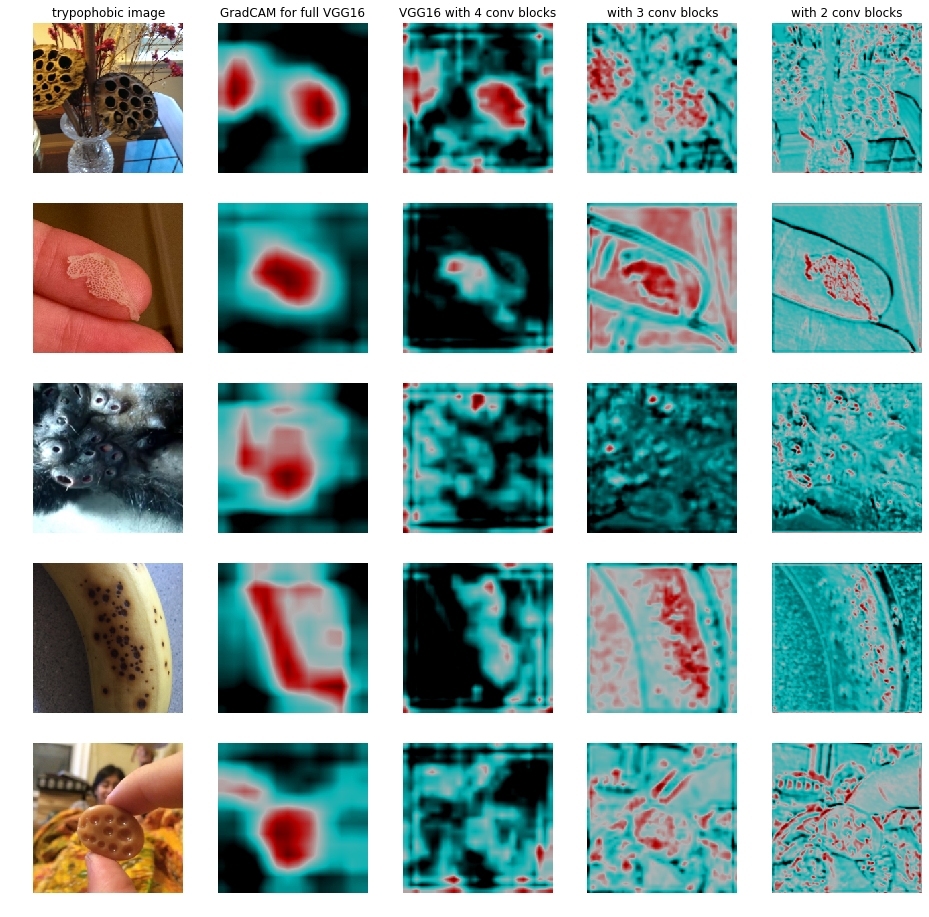

In [22]:

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))
#fig.tight_layout()
for i, path in enumerate(paths):
    img = plt.imread(path)
    img = cv2.resize(img, (224, 224))
    ax[i, 0].imshow(img)
    ax[i, 0].axis('off')
    ax[0, 0].set_title('trypophobic image')
    grad1 = plt.imread('full_'+str(i)+'.png')
    ax[i, 1].imshow(grad1)
    ax[i, 1].axis('off')
    ax[0, 1].set_title('GradCAM for full VGG16')
    grad2 = plt.imread('block4_'+str(i)+'.png')
    ax[i, 2].imshow(grad2)
    ax[i, 2].axis('off')
    ax[0, 2].set_title('VGG16 with 4 conv blocks')
    grad3 = plt.imread('block3_'+str(i)+'.png')
    ax[i, 3].imshow(grad3)
    ax[i, 3].axis('off')
    ax[0, 3].set_title('with 3 conv blocks')
    grad4 = plt.imread('block2_'+str(i)+'.png')
    ax[i, 4].imshow(grad4)
    ax[i, 4].axis('off')
    ax[0, 4].set_title('with 2 conv blocks')

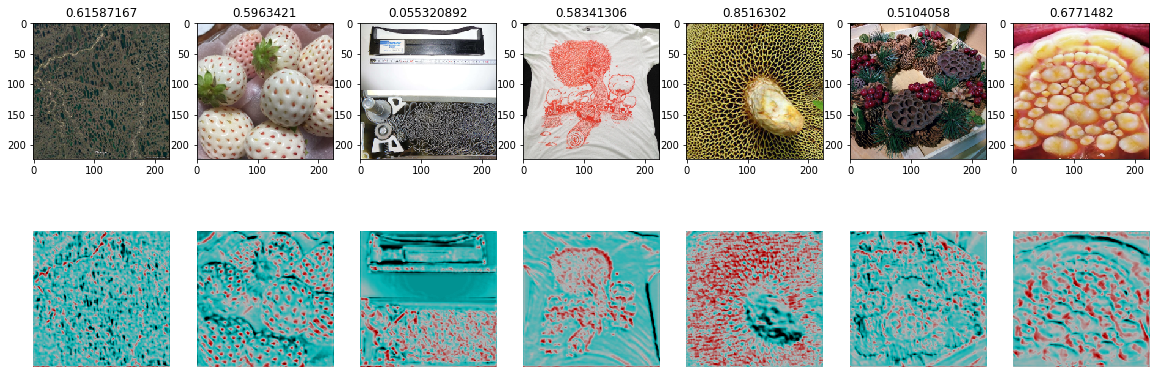

In [27]:
DIR_PATH = '/mnt/mydata/valid/trypo'

fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(20, 7))
for i in range(7):
    filename = random.choice(os.listdir(DIR_PATH))
    filepath = DIR_PATH+'/'+filename
    
    img = plt.imread(filepath)
    img = cv2.resize(img, (224, 224))
    img = img[np.newaxis, :]
    pred = model.predict(img)[0][0]
    ax[0, i].imshow(img[0])
    ax[0, i].set_title(pred)
    heatmap = calculate_heatmap(model, img)
    superimposed_img = get_superposition(heatmap, img[0], pred)
    ax[1, i].imshow(superimposed_img)
    ax[1, i].axis('off')